In [1]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, hstack, vstack
import matplotlib.pyplot as plt 
import numpy as np
from astroML.stats import binned_statistic_2d
from collections import Counter
import pandas as pd
from astroML.plotting import hist
from astropy.time import Time
%matplotlib inline

# Read HLC, NSC, and GAIA  

I needed to split the catalogues into *several* files just to read them.

In [2]:

#------------------------HLC-----------------------#

hlc1=Table.read('HLC.RA_00_to_01.fits.gz')
hlc2=Table.read('HLC.RA_01_to_02.fits.gz')
hlc3=Table.read('HLC.RA_02_to_03.fits.gz')
hlc4=Table.read('HLC.RA_03_to_04.fits.gz')
hlc5=Table.read('HLC.RA_20_to_21.fits.gz')
hlc6=Table.read('HLC.RA_21_to_22.fits.gz')
hlc7=Table.read('HLC.RA_22_to_23.fits.gz')
hlc8=Table.read('HLC.RA_23_to_24.fits.gz')


#------------------------NSC------------------------#

nsc1=Table.read('stripe82_315_ra_45_-1_3_dec_0.csv', format='ascii', data_end=499999)
nsc2=Table.read('stripe82_315_ra_45_-1_3_dec_0.csv', format='ascii', data_start=500000, data_end=999999)
nsc3=Table.read('stripe82_315_ra_45_-1_3_dec_0.csv', format='ascii', data_start=1000000, data_end=1499999)
nsc4=Table.read('stripe82_315_ra_45_-1_3_dec_0.csv', format='ascii', data_start=1500000, data_end=1999999)
nsc5=Table.read('stripe82_315_ra_45_-1_3_dec_0.csv', format='ascii', data_start=2000000, data_end=2499999)
nsc6=Table.read('stripe82_315_ra_45_-1_3_dec_0.csv', format='ascii', data_start=2500000, data_end=2999999)
nsc7=Table.read('stripe82_315_ra_45_-1_3_dec_0.csv', format='ascii', data_start=3000000, data_end=3499999)
nsc8=Table.read('stripe82_315_ra_45_-1_3_dec_0.csv', format='ascii', data_start=3500000, data_end=3999999)

nsc9=Table.read('stripe82_315_ra_45_0_dec_1_3.csv', format='ascii', data_end=499999)
nsc10=Table.read('stripe82_315_ra_45_0_dec_1_3.csv', format='ascii', data_start=500000, data_end=999999)
nsc11=Table.read('stripe82_315_ra_45_0_dec_1_3.csv', format='ascii', data_start=1000000, data_end=1499999)
nsc12=Table.read('stripe82_315_ra_45_0_dec_1_3.csv', format='ascii', data_start=1500000, data_end=1999999)
nsc13=Table.read('stripe82_315_ra_45_0_dec_1_3.csv', format='ascii', data_start=2000000, data_end=2499999)
nsc14=Table.read('stripe82_315_ra_45_0_dec_1_3.csv', format='ascii', data_start=2500000, data_end=2999999)
nsc15=Table.read('stripe82_315_ra_45_0_dec_1_3.csv', format='ascii', data_start=3000000, data_end=3499999)

#------------------------Gaia-----------------------#
colnames = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr']
gaia = Table.read('Stripe82_GaiaDR1.dat.gz', format='ascii', names=colnames)




# Crossmatch HLC and NSC with Gaia  


There were still multiple matches with the 0.5 arcsecond distance, so I created a code that automatically finds the closest match.

In [19]:
#--------------------------------Function to Filter Out Closest Matches---------------------------------#

def close_match(idx,dist):
    #----------Make list of duplicates--------------------#
    
    #  Count duplicates
    count=Counter(idx)
    #  Turn list into array
    count=list(count.items())
    count=np.array(count)
    #  Make mask of multiple matches
    multimatch=count[:,1]>1
    
    #-------------Match Multiples in Indices array----------------#
    
    #  Here, I'm going to create a massive list of the indices of matches I want to throw away.
    
    match=[]
    b=[]
    
    for indice in count[multimatch][:,0]:
        #Create mask to find multiple indicies
        a=np.where(idx==indice)[0]
        #Append matches to list
        match.append([a,idx[a],dist[a]])
        #Create mask to find the minimum distance within the matches
        b.append(dist[a]==min(d for d in dist[a]))
        
    #  Apply the mask to this weird "match" list and make a new list of the wrong 
    #  indice matches using the '~'.
    
    wrong=[]
    
    for i in range(len(match)):
       wrong.append(match[i][0][~b[i]])
    

    #  Concatenate list of indicies into "badmatch"
    badmatch=np.concatenate(wrong, axis=0)
    
    #---------------------Final list of matches and indices to throw away---------------------#
    idxnew=np.delete(idx,badmatch)
    
    idx_list=np.array(range(len(idx)))
    delmulti=np.delete(idx_list, badmatch)
    
    return(delmulti,idxnew)



#---------------------------------------------Crossmatch HLC---------------------------------------------#

def crossmatch_hlc_gaia(hlc, gaia):

    
    #------------------Read RA and DEC------------------#
    
    hlcra   = hlc['RA_MEAN']
    hlcdec  = hlc['DEC_MEAN']
    gaiara  = gaia['ra']
    gaiadec = gaia['dec']
    
    #----------------Create coodinates------------------#
    
    HLCcoords = SkyCoord(ra = hlcra*u.degree, dec= hlcdec*u.degree) 
    GAIAcoords = SkyCoord(ra = gaiara*u.degree, dec= gaiadec*u.degree)
    
    #-----------------Match HLC and Gaia---------------#
    
    hidx, hd2d, hd3d = HLCcoords.match_to_catalog_sky(GAIAcoords)
    
    #-----------distance filter (0.5arcseconds)----------#
    
    #halfarc=0.000138889  #0.5arcs
    #hdist=np.array(hd2d)<halfarc
    
    #----------------New HLC and NSC tables-------------#
    
    #-----run multiple matches----#
    
    hdelmulti, hidxnew=close_match(hidx,hd2d)
    
    #----Delete indicies with "not best" matches----#
    
    gaia_hlc=gaia[hidxnew]
    
    hlc_new=hlc[hdelmulti]
    
    
    #----Stack tables------#
    hg=hstack([hlc_new,gaia_hlc])
    
    return(hg)



#------------------------------------------------Crossmatch NSC------------------------------------------#

def crossmatch_nsc_gaia(nsc, gaia):

    
    #------------------Read RA and DEC------------------#
    
    nscra   = nsc['ra']
    nscdec  = nsc['dec']
    gaiara  = gaia['ra']
    gaiadec = gaia['dec']
    
    #----------------Create coodinates------------------#
    
    GAIAcoords = SkyCoord(ra = gaiara*u.degree, dec= gaiadec*u.degree)
    NSCcoords = SkyCoord(ra = nscra*u.degree, dec= nscdec*u.degree)
    
    #-----------------Match HLC and Gaia---------------#
    
    nidx, nd2d, nd3d = NSCcoords.match_to_catalog_sky(GAIAcoords)
    
    #-----------distance filter (0.5arcseconds)----------#
    
    #halfarc=0.000138889  #0.5arcs
    #ndist=np.array(nd2d)<halfarc
    
    
    #----------------New HLC and NSC tables-------------#
    
    #-----run multiple matches----#
    ndelmulti, nidxnew=close_match(nidx,nd2d)
    
    #----Delete indicies with "not best" matches----#
    
    gaia_nsc=gaia[nidxnew]
    
    nsc_new=nsc[ndelmulti]
    
    #----Stack tables------#
    
    ng=hstack([nsc_new,gaia_nsc])
    
    return(ng)







In [24]:
%%time
mng=vstack([ng1,ng2])
print('Done')

Done
CPU times: user 35.3 ms, sys: 7.55 ms, total: 42.8 ms
Wall time: 41.9 ms


In [ ]:
#------List of tables-----------------#


#------GAIA_HLC----------#

hg1 = crossmatch_hlc_gaia(hlc1, gaia)    #Can't work with wrapping degrees yet
hg2 = crossmatch_hlc_gaia(hlc2, gaia)
hg3 = crossmatch_hlc_gaia(hlc3, gaia)
hg4 = crossmatch_hlc_gaia(hlc4, gaia)
hg5 = crossmatch_hlc_gaia(hlc5, gaia)    #Can't work with wrapping degrees yet
hg6 = crossmatch_hlc_gaia(hlc6, gaia)
hg7 = crossmatch_hlc_gaia(hlc7, gaia)
hg8 = crossmatch_hlc_gaia(hlc8, gaia)    #Can't work with wrapping degrees yet


table2=vstack([table1,hg6,g7])
mhg=vstack([table2,hg8])

#------GAIA_NSC----------#

ng1 = crossmatch_nsc_gaia(nsc1, gaia)
ng2 = crossmatch_nsc_gaia(nsc1, gaia)
ng3 = crossmatch_nsc_gaia(nsc1, gaia)
ng4 = crossmatch_nsc_gaia(nsc1, gaia)
ng5 = crossmatch_nsc_gaia(nsc1, gaia)
ng6 = crossmatch_nsc_gaia(nsc1, gaia)
ng7 = crossmatch_nsc_gaia(nsc1, gaia)
ng8 = crossmatch_nsc_gaia(nsc1, gaia)
ng9 = crossmatch_nsc_gaia(nsc1, gaia)
ng10 = crossmatch_nsc_gaia(nsc1, gaia)
ng11 = crossmatch_nsc_gaia(nsc1, gaia)
ng12 = crossmatch_nsc_gaia(nsc1, gaia)
ng13 = crossmatch_nsc_gaia(nsc1, gaia)
ng14 = crossmatch_nsc_gaia(nsc1, gaia)
ng15 = crossmatch_nsc_gaia(nsc1, gaia)


table3=vstack([ng1,ng2,ng3])
table4=vstack([table3,ng4,ng5])
table5=vstack([table4,ng6,ng7])
table6=vstack([table5,ng8,ng9])
table7=vstack([table6,ng10,ng11])
table8=vstack([table7,ng12,ng13])
mng=vstack([table8,ng14,ng15])

In [470]:
print ('# of GAIA_HLC Sources ==  ',len(mhg),'\n','# of GAIA_NSC Sources ==  ' ,len(mng))

# of GAIA_HLC Sources ==   527136 
 # of GAIA_NSC Sources ==   554895


# Positions

In [546]:
def dpos(hg,ng):
    
    #RA and DEC
    
    HLCra=hg['RA_MEAN']
    HLCdec=hg['DEC_MEAN']
    NSCra=ng['ra_1']
    NSCdec=ng['dec_1']
    GAIA_HLCra=hg['ra']
    GAIA_HLCdec=hg['dec']
    GAIA_NSCra=ng['ra_2']
    GAIA_NSCdec=ng['dec_2']

    # dpos
    hdra  = (HLCra-GAIA_HLCra)
    hddec = (HLCdec-GAIA_HLCdec)
    ndra  = (NSCra-GAIA_NSCra)
    nddec = (NSCdec-GAIA_NSCdec)
    
    #------------Plot HLC_GAIA--------------#
    plt.style.use('ggplot')
    fig = plt.figure(figsize=[20,6])
    
    #-----dra vs ddec------#
    
    ax = plt.subplot(131)
    
    plt.ylabel('$dDEC$')
    plt.xlabel('$dRA$')
    plt.scatter(hdra,hddec, s=3, c='k')
    plt.axvline(x=0, c='red', linestyle='--')
    plt.axhline(y=0, c='red', linestyle='--')
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.05, 0.05)
    
    #-----dra hist------#
    ax = plt.subplot(132)
    
    plt.title('HLC_GAIA')
    plt.xlabel('$dRA$')
    plt.ylabel('$N$')
    hist(hdra, bins=20000000, histtype='stepfilled', ec='k', fc='orange')
    plt.axvline(x=0, c='red', linestyle='--')
    plt.xlim(-0.0003,0.0003)
    #-----dra hist------#
    ax = plt.subplot(133)
    
    plt.xlabel('$dDEC$')
    plt.ylabel('$N$')
    hist(hddec, bins=5000, histtype='stepfilled', ec='k', fc='orange')
    plt.axvline(x=0, c='red', linestyle='--')
    plt.xlim(-0.0003,0.0004)
    
    print ('dRA Median HLC =   ', np.median(hdra))
    print ('dRA std HLC =   ', np.std(hdra))
    print ('dDEC Median HLC =   ',np.median(hddec))
    print ('dDEC std HLC =   ', np.std(hddec))
    
    plt.show()
    
     #------------Plot NSC_GAIA--------------#
    
    fig = plt.figure(figsize=[20,6])
    
    #-----dra vs ddec------#
    
    ax = plt.subplot(131)
    
    plt.ylabel('$dDEC$')
    plt.xlabel('$dRA$')
    plt.scatter(ndra,nddec, s=3, c='k')
    plt.axvline(x=0, c='red', linestyle='--')
    plt.axhline(y=0, c='red', linestyle='--')
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.04, 0.04)
    
    #-----dra hist------#
    ax = plt.subplot(132)
    
    plt.title('NSC_GAIA')
    plt.xlabel('$dRA$')
    plt.ylabel('$N$')
    hist(ndra, bins=500000, histtype='stepfilled', ec='k', fc='orange')
    plt.axvline(x=0, c='red', linestyle='--')
    plt.xlim(-0.00003,0.00003)
    #-----dra hist------#
    ax = plt.subplot(133)
    
    plt.xlabel('$dDEC$')
    plt.ylabel('$N$')
    hist(nddec, bins=50000, histtype='stepfilled', ec='k', fc='orange')
    plt.axvline(x=0, c='red', linestyle='--')
    plt.xlim(-0.00003,0.00003)
    
    print ('dRA Median NSC  =   ', np.median(ndra))
    print ('dRA std NSC =   ', np.std(ndra))
    print ('dDEC Median NSC =   ',np.median(nddec))
    print ('dDEC std NSC =   ', np.std(nddec))
    
    plt.show()

dRA Median HLC =    -1.27415194697e-05
dRA std HLC =    3.21320161622
dDEC Median HLC =    2.41782830683e-05
dDEC std HLC =    0.000700419529259


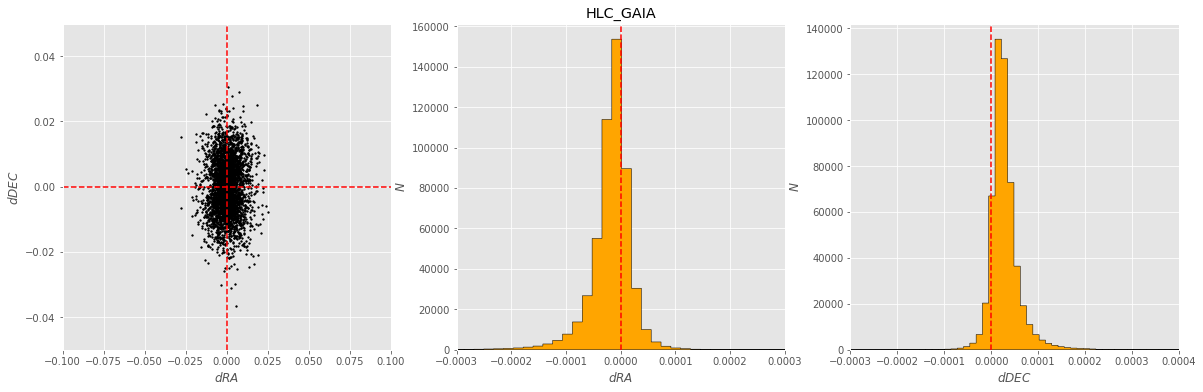

dRA Median NSC  =    -1.69630311575e-07
dRA std NSC =    0.00725760832197
dDEC Median NSC =    1.14264057316e-06
dDEC std NSC =    0.000873377029856


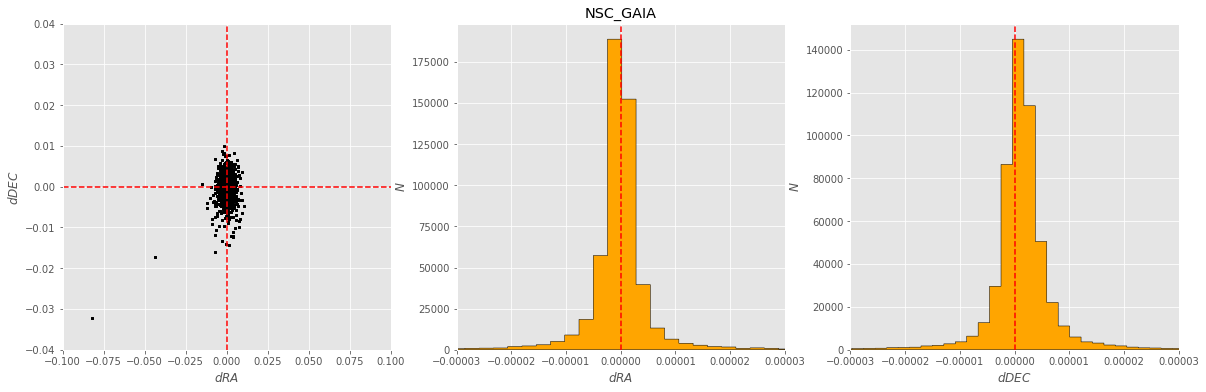

In [547]:
dpos(mhg,mng)

# Proper Motions  

(Because my computer is slow, I am only comparing (hlc2,hlc3,hlc4) and (nsc1,nsc2) here. If you have a faster one, feel free to run the entire code.)

Here, we compare the proper motions between HLC and NSC. Whichever one is better will have a smaller change in position compared to the GAIA catalogue after adding the measured proper motion values. I really needed the HJD from the LMCC catalogues, but I'm just using the mean HLC date, September 15, 2002 (2452532.75054JD), the mean NSC date (2456782.4517588825JD), and the release GAIA date (2457645.75054JD).

In [46]:
#-----Times(HJD)--------#
hlc_time=Time(2452532.75054, format='jd')
nsc_time=Time(np.median(mng['mjd'])+2400000.5, format='jd')
gaia_time=Time(2457645.75054, format='jd')

mhg_dt=gaia_time.decimalyear-hlc_time.decimalyear
mng_dt=gaia_time.decimalyear-nsc_time.decimalyear

def dpm(hg,ng):
    

    #-----------------dPM----------------------------#
    
    #RA and DEC in mas
    
    HLCra=hg['RA_MEAN']*3600
    HLCdec=hg['DEC_MEAN']*3600
    NSCra=ng['ra_1']*3600
    NSCdec=ng['dec_1']*3600
    GAIA_HLCra=hg['ra']*3600
    GAIA_HLCdec=hg['dec']*3600
    GAIA_NSCra=ng['ra_2']*3600
    GAIA_NSCdec=ng['dec_2']*3600
    
    # HLC proper motions
    HLCpmRA = hg['RA_PM']
    HLCpmRAerr = hg['RA_PM_ERR']
    HLCpmDec = hg['DEC_PM']
    HLCpmDecerr = hg['DEC_PM_ERR']
    
    # NSC proper motions 
    NSCpmRA = ng['pmra']
    NSCpmRAerr = ng['pmraerr']
    NSCpmDec = ng['pmdec']
    NSCpmDecerr = ng['pmdecerr']
    
    
    #Multiply proper motions by change in time
    HLCra_new=HLCra+(HLCpmRA*mhg_dt)
    HLCdec_new=HLCdec+(HLCpmDec*mhg_dt)
    NSCra_new=NSCra+(NSCpmRA*mng_dt)
    NSCdec_new=NSCdec+(NSCpmDec*mng_dt)
    
    # Difference between GAIA positions and projected HLC and NSC positions
    hdra_new = HLCra_new - GAIA_HLCra
    hddec_new = HLCdec_new -GAIA_HLCdec
    ndra_new = NSCra_new - GAIA_NSCra
    nddec_new = NSCdec_new - GAIA_NSCdec
    
    #----------------------------------plot--------------------------------#
    
    #------------Plot HLC_GAIA--------------#
    plt.style.use('ggplot')
    fig = plt.figure(figsize=[20,6])
    
    #-----dra vs ddec------#
    
    ax = plt.subplot(131)
    
    plt.ylabel('$dDEC_{new}$ mas')
    plt.xlabel('$dRA_{new}$ mas')
    plt.scatter(hdra_new,hddec_new, s=3, c='k')
    plt.axvline(x=0, c='red', linestyle='--')
    plt.axhline(y=0, c='red', linestyle='--')
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    
    #-----dra hist------#
    ax = plt.subplot(132)
    
    plt.title('HLC_GAIA_new')
    plt.xlabel('$dRA_{new}$ mas')
    plt.ylabel('$N$')
    hist(hdra_new, bins=5000, histtype='stepfilled', ec='k', fc='c')
    plt.axvline(x=0, c='red', linestyle='--')
    plt.xlim(-1,1)
    #-----dra hist------#
    ax = plt.subplot(133)
    
    plt.xlabel('$dDEC_{new}$ mas')
    plt.ylabel('$N$')
    hist(hddec_new, bins=5000, histtype='stepfilled', ec='k', fc='c')
    plt.axvline(x=0, c='red', linestyle='--')
    plt.xlim(-1,1)
    
    print ('dRA Median HLC_new =   ', np.median(hdra_new))
    print ('dRA std HLC_new =   ', np.std(hdra_new))
    print ('dDEC Median HLC_new =   ',np.median(hddec_new))
    print ('dDEC std HLC_new =   ', np.std(hddec_new))
    
    plt.show()
    
    #------------Plot HLC_GAIA--------------#
    plt.style.use('ggplot')
    fig = plt.figure(figsize=[20,6])
    
    #-----dra vs ddec------#
    
    ax = plt.subplot(131)
    
    plt.ylabel('$dDEC_{new}$ mas')
    plt.xlabel('$dRA_{new}$ mas')
    plt.scatter(ndra_new,nddec_new, s=3, c='k')
    plt.axvline(x=0, c='red', linestyle='--')
    plt.axhline(y=0, c='red', linestyle='--')
    #plt.xlim(-5, 5)
    #plt.ylim(-5, 5)
    
    #-----dra hist------#
    ax = plt.subplot(132)
    
    plt.title('NSC_GAIA_new')
    plt.xlabel('$dRA_{new}$ mas')
    plt.ylabel('$N$')
    hist(ndra_new, bins=8000000, histtype='stepfilled', ec='k', fc='c')
    plt.axvline(x=0, c='red', linestyle='--')
    plt.xlim(-200,200)
    #-----dra hist------#
    #ax = plt.subplot(133)
    
    #plt.xlabel('$dDEC_{new}$ mas')
    #plt.ylabel('$N$')
    #hist(nddec_new, bins=500000, histtype='stepfilled', ec='k', fc='c')
    #plt.axvline(x=0, c='red', linestyle='--')
    #plt.xlim(-1,1)
    
    print ('dRA Median NsC_new =   ', np.median(ndra_new))
    print ('dRA std NSC_new =   ', np.std(ndra_new))
    print ('dDEC Median NSC_new =   ',np.median(nddec_new))
    print ('dDEC std NSC_new =   ', np.std(nddec_new))
    
    plt.show()
    

dRA Median HLC_new =    -0.00155770024867
dRA std HLC_new =    2.49238216362
dDEC Median HLC_new =    0.00102695790031
dDEC std HLC_new =    3.34640369953


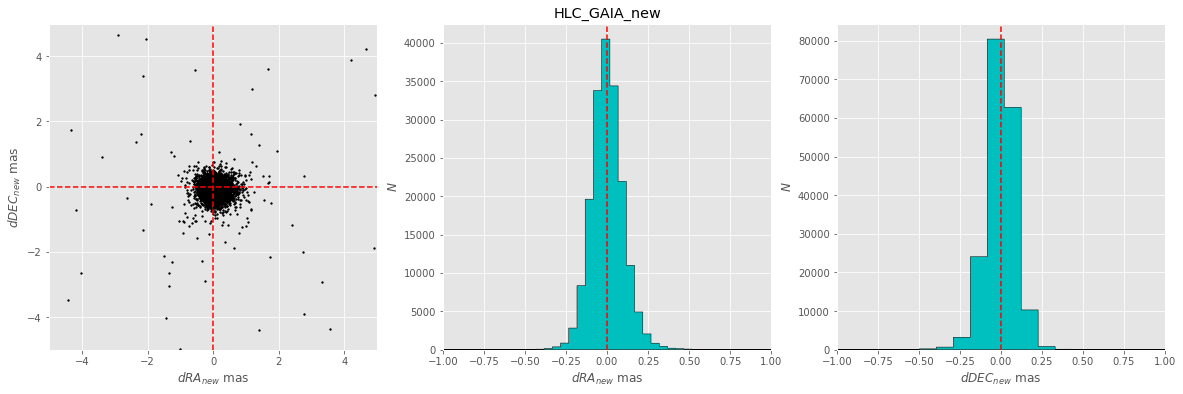

dRA Median NsC_new =    -0.756383314263
dRA std NSC_new =    355796.762288
dDEC Median NSC_new =    -0.669727251369
dDEC std NSC_new =    nan


/Users/BriBri/miniconda3/envs/astroconda36/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


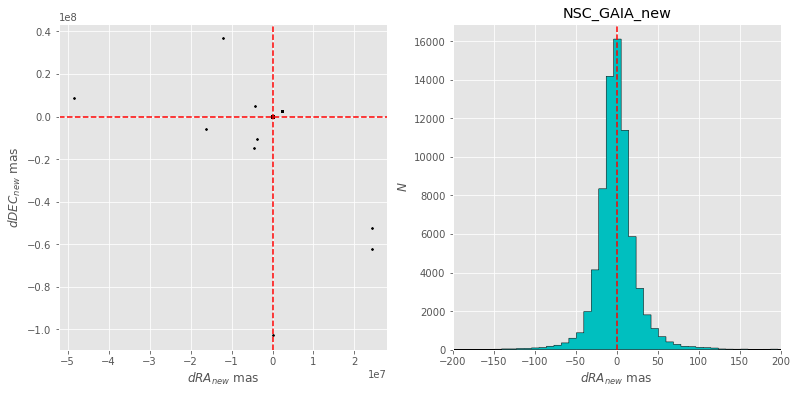

In [47]:
dpm(mhg,mng)

# Future Work  

The obvious one is that my NSC_GAIA matches are in clusters (help!). I have the same result when I run it on all of the nsc files.  

Also, my statistics are a bit off because I didn't account for wrapped degree positions (example below) and the clusters. I can figure out how to wrap them or take them out later to make the numbers more accurate. However, I just used limits to zoom in on the main objects. 

I also need to use the right bin sizes for the histograms.  

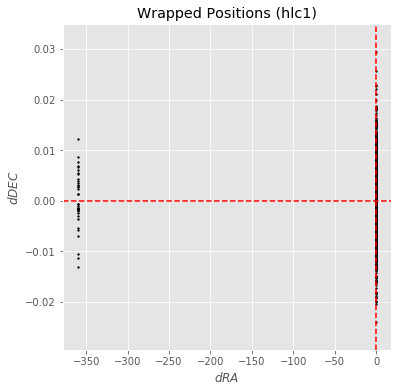

In [50]:
HLCra=hg1['RA_MEAN']
HLCdec=hg1['DEC_MEAN']
GAIA_HLCra=hg1['ra']
GAIA_HLCdec=hg1['dec']
hdra  = (HLCra-GAIA_HLCra)
hddec = (HLCdec-GAIA_HLCdec)

plt.style.use('ggplot')
fig = plt.figure(figsize=[20,6])

#-----dra vs ddec------#

ax = plt.subplot(131)

plt.title("Wrapped Positions (hlc1)")
plt.ylabel('$dDEC$')
plt.xlabel('$dRA$')
plt.scatter(hdra,hddec, s=3, c='k')
plt.axvline(x=0, c='red', linestyle='--')
plt.axhline(y=0, c='red', linestyle='--')
plt.show()